# Machine Learning  & Pytorch

![Meme](https://miro.medium.com/max/700/1*x7P7gqjo8k2_bj2rTQWAfg.jpeg)


### Contents

![Meme](https://i.imgur.com/oJEQe7k.png)


### Machine Learning  
1. Linear Regression: http://adit.io/posts/2016-02-20-Linear-Regression-in-Pictures.html
2. Least Squares 
3. Linear Classifier  http://adit.io/posts/2016-03-13-Logistic-Regression.html#non-linear-classification








### PyTorch

1. PyTorch Basics
2. Dataset
3. DataLoader
4. Model
5. Objectives, Optimizers and the Training Loop



### Linear Regression

Best fit line to a dataset. We want to reach a minimum error via gradient descent. Take steps by calculating gradient at points on the error function versus theta graph. The minima helps chose the right thethas. Thetas here are the parameters of the function we want to get.

In [0]:
# Installation 
!pip3 install torch torchvision 

In [0]:
import torch
from torch import nn, optim
from matplotlib import pyplot
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

pyplot.rc('font', size=SMALL_SIZE)          # Controls default text sizes
pyplot.rc('axes', titlesize=SMALL_SIZE)     # Fontsize of the axes title
pyplot.rc('axes', labelsize=MEDIUM_SIZE)    # Fontsize of the x and y labels
pyplot.rc('xtick', labelsize=SMALL_SIZE)    # Fontsize of the xtick labels
pyplot.rc('ytick', labelsize=SMALL_SIZE)    # Fontsize of the ytick labels
pyplot.rc('legend', fontsize=SMALL_SIZE)    # Legend fontsize
pyplot.rc('figure', titlesize=BIGGER_SIZE)  # Fontsize of the figure title

In [3]:
A = torch.Tensor([1, 2, 3])
A

tensor([1., 2., 3.])

In [4]:
B = A + 3 # Supports broadcast operations, like numpy.
B

tensor([4., 5., 6.])

#### `np.ndarray`?
#### `tf.Tensor`?
#### `torch.Tensor`!



### Why `torch.Tensor`?

* `autograd` enabled: No longer necessary to compute gradient update rules manually.
* CUDA backend: Operations are many orders faster than numpy, which is not as fast.

## Today's excercise

Create a 2D synthetic data (Normal distribution) of 1000 samples that is,
$(x^1, x^2)$ from two classes with 50% in each of these classes.

You may chose your favorite mean and covariance. But make sure that a
linear classifier will have error (Say the best possible error is in the
range 50-250 samples)

...



![](https://www.mathworks.com/help/stats/machinelearning_supervisedunsupervised.png)



### `torch.utils.data.Dataset`

We'll implement the 2D data in question as a `Dataset`. 

A dataset is something which requires a finite length, and indexed access gets a `(sample, target)` pair.

In [0]:
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.utils.data

class FakeDataset(torch.utils.data.Dataset):
    # Load all the data and stats
    def __init__(self, mean, covariance, class_id, samples):
        self.distribution = MultivariateNormal(mean, covariance)
        self.class_id = class_id
        self.samples = samples
        self.mean = mean
        self.covariance = covariance
        
        self.data = self.generate_samples()
    
    def generate_samples(self):
        data = []
        for i in range(self.samples):
            sample = self.distribution.sample()
            data.append(sample)
        return data
    # Length of the dataset
    def __len__(self):
        return self.samples
    
    # Get a particular datapoint and information 
    def __getitem__(self, idx):
        return (self.data[idx], self.class_id)

In [0]:
samples = 500

mean, covariance = torch.tensor([1, 1]).float(), torch.eye(2, 2).float()
first = FakeDataset(mean, covariance, class_id=0, samples=samples)

mean, covariance = torch.tensor([3, 3]).float(), torch.eye(2, 2).float()
second = FakeDataset(mean, covariance, class_id=1, samples=samples)

\begin{align*}
\mu_0 &= \begin{bmatrix} 1 \\ 1\end{bmatrix} & \Sigma_0 &= \begin{bmatrix}1 & 0 \\0 &1 \end{bmatrix} & \text{# class 0} \\
\mu_1 &= \begin{bmatrix} 3 \\ 3\end{bmatrix} & \Sigma_1 &= \begin{bmatrix}1 & 0 \\0 &1 \end{bmatrix} & \text{# class 1}
\end{align*}



###`torch.utils.data.DataLoader`

A `DataLoader` is an abstraction which enables fast and parallel loading of data (images, videos et cetera) and provides options for batching, shuffling and splitting the `Dataset`. 

`Transforms` additionally help in preprocessing data (feature extraction) which are also built into the dataloader. 

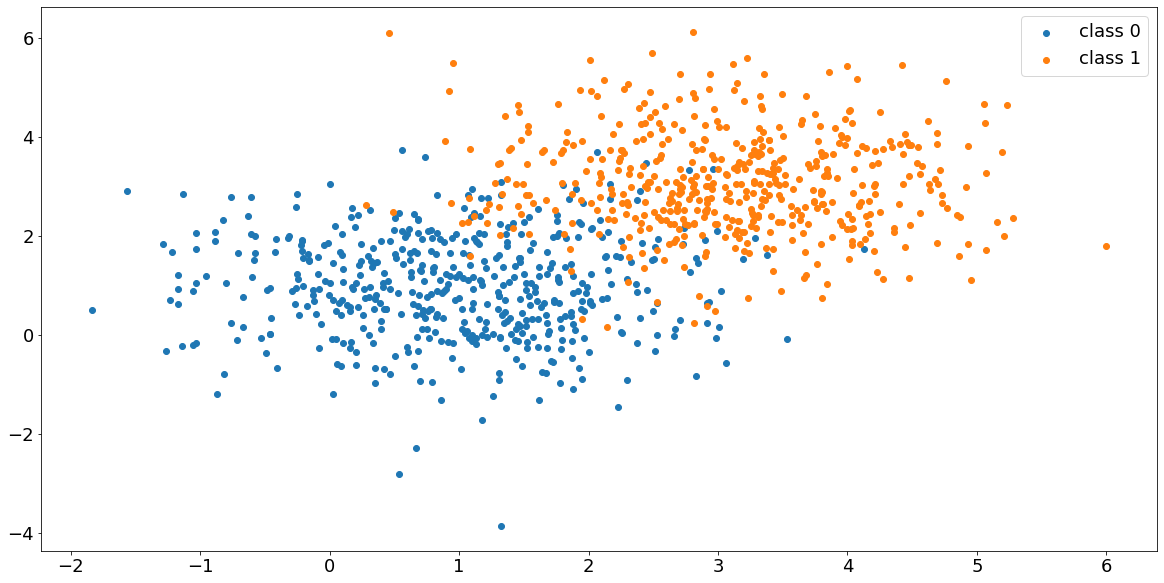

In [7]:
dataset = torch.utils.data.ConcatDataset([first, second])
loader = torch.utils.data.DataLoader(dataset, shuffle=True)

def visualize_datapoints(first, second, boundaries=[]):
    def datapoints(dset):
        loader = torch.utils.data.DataLoader(dset, batch_size=len(dset))
        pts, labels = next(iter(loader))
        xys = pts.numpy()
        xs, ys = xys[:, 0], xys[:, 1]
        return (xs, ys)
        
    xs, ys = datapoints(first)
    pyplot.figure(figsize=(20, 10))
    pyplot.scatter(xs, ys, label='class 0')
    
    xs, ys = datapoints(second)
    pyplot.scatter(xs, ys, label='class 1')
    
    def draw(boundary):
        w, title  = boundary
        eps = 1e-9
        f = lambda x: -(w[0] + w[1]*x)/(w[2] + eps)
        xs = torch.linspace(start=-1, end=+5, steps=100)
        ys = f(xs)
        pyplot.plot(xs.numpy(), ys.numpy(), label=title)
    for boundary in boundaries:
        draw(boundary)
    
    pyplot.legend()
    return pyplot

_ = visualize_datapoints(first, second)

### Model 

Learn a Linear classifier with gradient descent. Find the
error on this data. (write your own code that implements gradient
descent. also submit the code). Repeat this with bias and without bias.
Do you find any difference?

Plot the decision boundaries (Bayesian optimal, LR with bias, LR without
bias) on a 2D plane and Submit. (show samples from different classes
with different colour.)

In [0]:
# Classifies the data 
class MultinomialLogisticRegressor(nn.Module):
    def __init__(self, input_feature_dim,  output_classes, bias=True):
        super().__init__()
        self.input_feature_dim = input_feature_dim
        self.output_classes = output_classes        
        self.W = nn.Linear(input_feature_dim, output_classes, bias=bias)
        
    def forward(self, input_feature):
        o = input_feature
        o = self.W(o)
        return o

In [0]:
print(MultinomialLogisticRegressor(10,2))

In [0]:
def run_epoch(loader, model, criterion, opt, device):
    total_loss, total_count = 0, 0
    
    model = model.to(device)
    for sample, target in loader:
        
        sample = sample.to(device)
        target = target.to(device)
        
        opt.zero_grad()   
        
        prediction = model(sample)
        loss = criterion(prediction, target)
        loss.backward()
        
        opt.step()
        
        total_loss += loss.item()
        total_count += 1
        
    return total_loss/total_count

### Gradient Updates

![](https://golden-media.s3.amazonaws.com/topic_images/48553e73ec8047d0a0739c8cd98b61f3.png)_


Before any computation, we clear out the existing gradients through `opt.zero_grad()`.

```python
for sample, target in loader:
    opt.zero_grad()   
```

The forward pass happens below.

```python
    prediction = model(sample)
```


Gradients for each parameter `x` are stored as an attribute, `x.grad`.

```python
    loss = criterion(prediction, target)
    loss.backward()
```

Now, all the optimizer has to do is visit each parameter and `x = x - eta * x.grad`. Which is achieved through the following function.


```python
    opt.step()
```

#### Resources

Basic implementations which helps see how autograd is implemented can be found below.

[CS 231 Lecture-4](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture4.pdf)


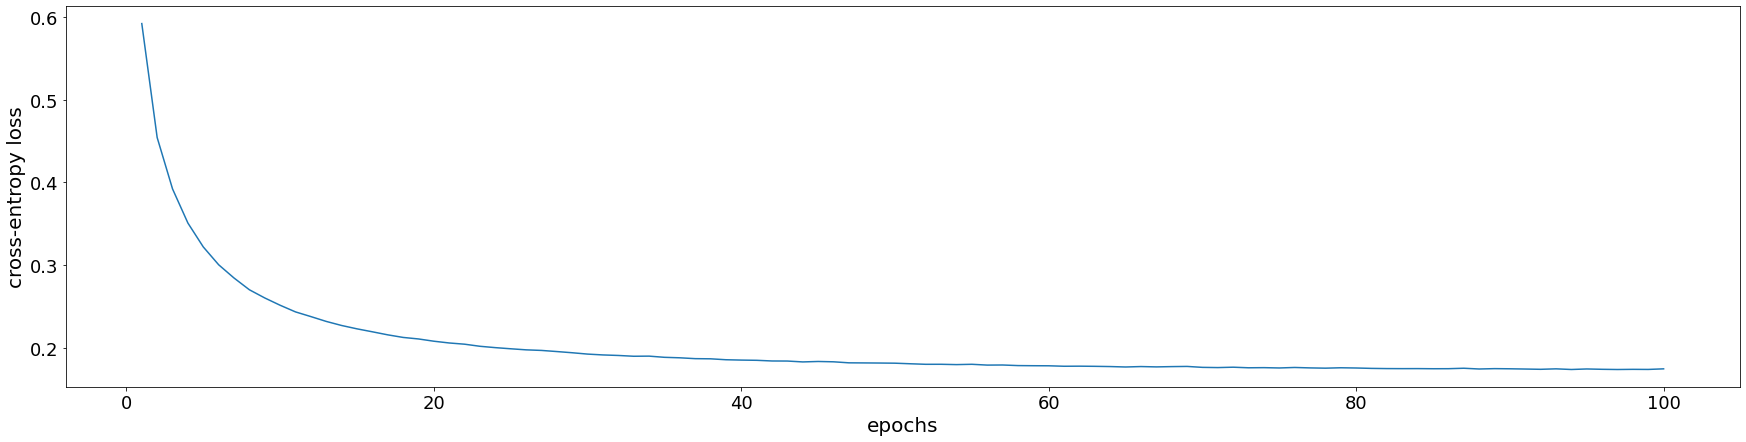

In [11]:
model = MultinomialLogisticRegressor(input_feature_dim=2, output_classes=2)
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(),  lr=1e-2, momentum=0.8)
max_epochs = 100


def train(max_epochs, loader, model, criterion, opt, device):
    losses = []
    for epoch in range(max_epochs):
        loss = run_epoch(loader, model, criterion, opt, device)
        losses.append(loss)
    return losses

# device = torch.device("cuda")
device = torch.device("cpu")
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=25)
losses = train(max_epochs, loader, model, criterion, opt, device)

def loss_plot(losses):
    max_epochs = len(losses)
    times = list(range(1, max_epochs+1))
    pyplot.figure(figsize=(30, 7))
    pyplot.xlabel("epochs")
    pyplot.ylabel("cross-entropy loss")
    return pyplot.plot(times, losses)

_ = loss_plot(losses)



We know that the probability for the two classes are given by the below functions.

\begin{align*}
f(0, x) &= {\bf \theta}_0^T{\bf x} & g(0, {\bf x}) &= (1 + \exp( f(0, {\bf x}) )^{-1} \\
f(1, x) &= {\bf \theta}_1^T{\bf x} & g(1, {\bf x}) &= (1 + \exp( f(1, {\bf x}) )^{-1} \\
\end{align*}

Decision boundary is given by $g(0, x) = g(1, x)$, which leads to $f(0, x) = f(1, x)$.

i.e, 
\begin{align*}
f(0, x) - f(1, x) &= 0 \implies & ({\bf \theta}_0 - {\bf \theta}_1)^T{\bf x} &= 0 
\end{align*}

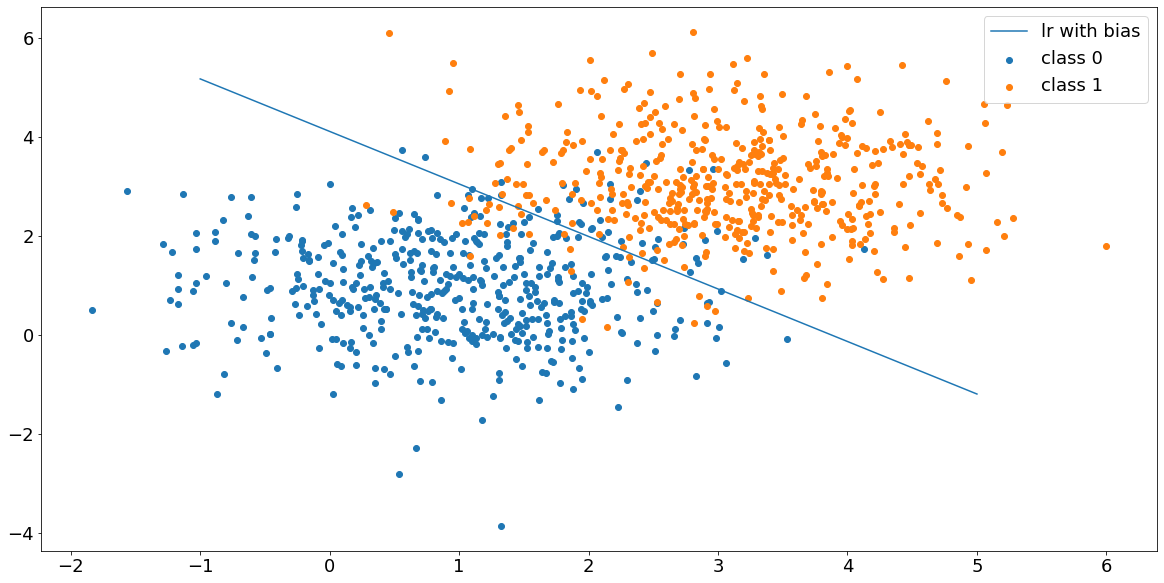

In [12]:
boundaries = model.W.parameters()
W, b = list(boundaries)
_W = W.new(2, 3)
_W[:,1:] = W.data
_W[:, 0] = b.data
w = _W[0, :] - _W[1, :]
w = w.cpu().numpy()

_ = visualize_datapoints(first, second, boundaries=[(w, 'lr with bias')])